# Title

In [18]:
import numpy as np  
#import numpy.random as random  
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline


# Part 1 - Travelling Salesman

## Introduction

The travelling salesman problem is a cornerstone of computational theory, and is often the reason for the underlying complexity of many other, seemingly unrelated computing problems. TSP involves finding the optimal route through a graph which minimises the total distance, while visiting every node at least once. A naive algorithm - such as the all-tours algorithm, which computes the distance for every possible path - has a computational complexity of $O(n!)$, and even the best deterministic algorithms that have been currently theorised have a complexity worse than exponential. The problem is classed as NP-Hard, meaning that not only is it hard to find a valid solution, but that confirming that solution is in itself a hard (NP-Complete) problem. It is very likely, but as of yet not proven, that no classical algorithm exists to solve any NP-Hard problem in polynomial time. Should such an algorithm be found, any NP-Hard problem would then be solvable in P, as transforming between NP-Hard problems can be done in polynomial time.

As hard as TSP may be, it is still possible to design algorithms that obtain an optimal route in a non-deterministic fashion, and still run at least somewhat efficiently. The reason behind the complexity of TSP is the very large sample space of possible solutions - by sampling only a sparse set of the solution space, and using the information obtained to guide the next sample, a Montecarlo solver provides a robust way of obtaining a result.

### Setting up the problem

In this specific case of TSP, the goal is to find the shortest path between a set of American state capitals. The coordinates of the cities are saved to a JSON file which must first be read and parsed, and a map of the country is also provided, as a visual help when displaying a path.

In [2]:
#section-specific modules

import json
import copy

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

map = mpimg.imread("map.png")  

In [3]:
# List of 30 US state capitals and corresponding coordinates on the map

with open('capitals.json', 'r') as capitals_file:
    capitals = json.load(capitals_file)    
capitals_list = list(capitals.items())

capitals_list = [(c[0], tuple(c[1])) for c in capitals_list]



The JSON file is parsed as a list of 2-tuples, where the first item is the name and the second is a tuple of (x,y) coordinates. For simplicity, a helper function is defined to transform this object into a list of coordinates. The path can also be visualised by plotting a series of lines between each coordinate pair in the list.

In [19]:
def coord(path):
        """Strip the city name from each element of the path list and return
        a list of tuples containing only pairs of xy coordinates for the
        cities. For example,
            [("Atlanta", (585.6, 376.8)), ...] -> [(585.6, 376.8), ...]
        """
        _, coord = path
        return coord

def coords(path):
        """Strip the city name from each element of the path list and return
        a list of tuples containing only pairs of xy coordinates for the
        cities. For example,
            [("Atlanta", (585.6, 376.8)), ...] -> [(585.6, 376.8), ...]
        """
        _, coords = zip(*path)
        return coords
    
def show_path(path_, starting_city, w=35, h=15):
    """Plot a TSP path overlaid on a map of the US States & their capitals."""
    path=coords(path_) 
    x, y = list(zip(*path))
    
    _, (x0, y0) = starting_city
    
    plt.imshow(map)
    plt.plot(x0, y0, 'y*', markersize=15)  # y* = yellow star for starting point
    plt.plot(x + x[:1], y + y[:1])  # include the starting point at the end of path
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])
    

[('Oklahoma City', (392.8, 356.4)), ('Montgomery', (559.6, 404.8)), ('Salt Lake City', (204.0, 243.2))]


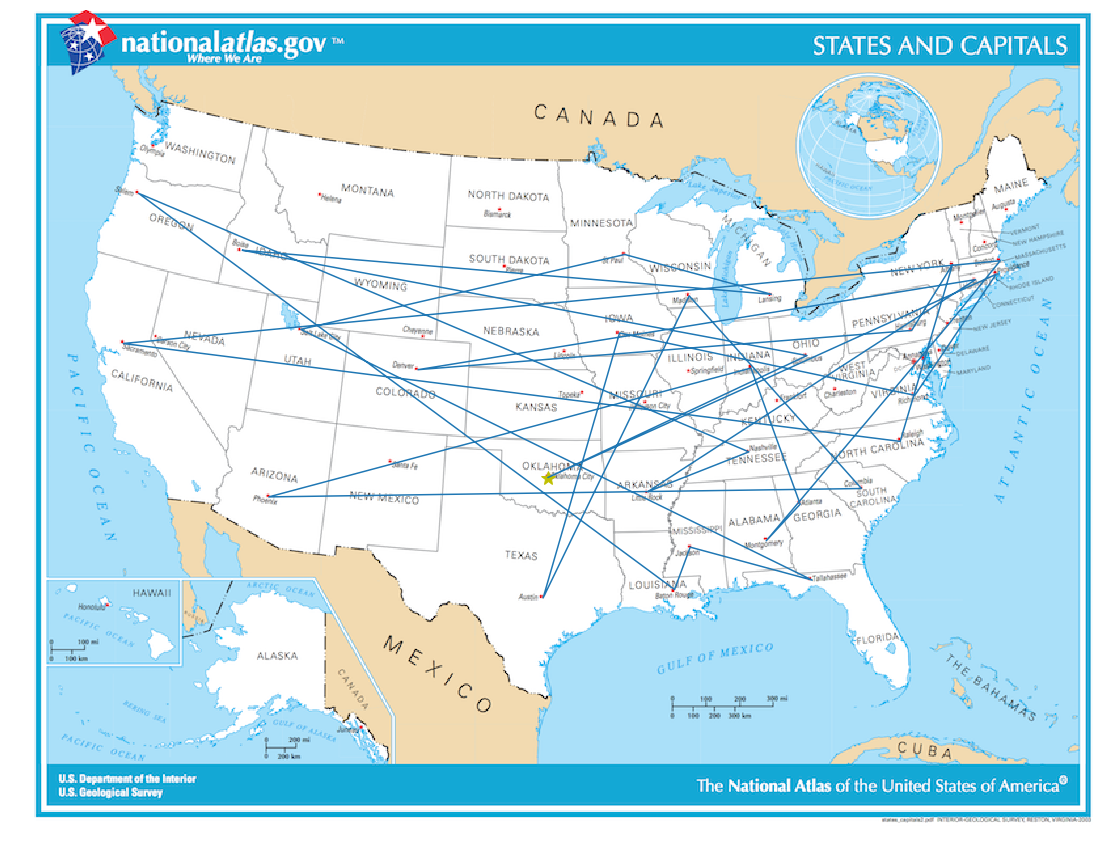

In [57]:
# Test with an arbitrary path

path = [capitals_list[0],capitals_list[1],capitals_list[4]]

print(path)

show_path(getPath(len(capitals_list)),capitals_list[0])

## Implementing a non-deterministic solver

Simulated annealing is an algorithm that is particularily well-suited to finding optimal solutions for TSP. At its core, it uses gradient descent to move towards a minimum in the space of solutions, by making a small change in the current configuration, and calculating the change in the function value to map out the local shape of the function. However, to avoid getting trapped in a local minimum, it does not always take a step in the direction of the decreasing function output, but rather has a chance, related to the current time, of taking a step even if the result would cause a temporary increase in the value of the function. 

In [24]:

#Define a temperature schedule
def temp(t, a = .95, t_0 = 1e8):
    return (a ** t) * t_0

#get a random starting path
def getPath(n=8):

    test_cities = []
    mod_capitals = list(capitals_list)

    for i in range(0,n):
        test_cities.append(mod_capitals.pop(np.random.randint(len(mod_capitals))))

    return test_cities

### Pairwise exchange

Every iteration, the algorithm must take a step in solution space by applying a small change to the previous path. There is more than one way to do this: for example, the most trivial is to directly switch two nodes in the path - for example, given the path

```
a b c d e f
```
switching node b and e would lead to

```
a e c d b f
```

This system is rather straightforward, and is usually fast to implement code-wise, as it runs in constant time. However, it modifies the path more than is strictly necessary, as both the incoming and outgoing paths of both swapped nodes will change: in the above example, the paths (a-b), (b-c), (d-e), (e-f) are deleted, and four new paths are created.
An alternative system is to switch the incoming path of b with the outgoing path of e, and vice-versa: that is, if we were to once again start from

```
a b c d e f
```

and decide to switch b and e, we'd get the following path

```
a e d c b f
```

calculated by slicing the list at the two chosen nodes, reversing the slice, and attaching it back in place. While this switching system is more complicated, both to code and to run (as it requires inverting part of the path, which pure python accomplishes in $O(n)$), only two paths have to be modified; (a-b) and (e-f) are deleted, and (a-e) and (b-f) are created. This means that the step taken is smaller, and therefore more likely to converge to a minimum, without skipping over it. Furthermore, it is possible to make the list reversal happen in constant time by using numpy arrays, which by default create a reversed view, rather than a reversed copy, of the array. While the array must still be copied at some point (to generate the new path), this avoids having to generate a reversed array, and then creating another array that is the concatenation of parts of the old path with the reversed array.

In [126]:
plt.rcParams["figure.figsize"] = (10,5)

def exchange(path):
    #choose two random points, and reverse the path between them - exclude the first and last item though, to avoid
    #problems with the path not being cyclic anymore
    
    a = 1 + np.random.randint(len(path) - 2)
    b = a + np.random.randint(1, len(path) - a)
    
    a = 1 + np.random.randint(len(path)-2)
    b = a + np.random.randint(1, len(path) - a)
    return path[:a] + path[b:a-1:-1] + path [b+1:]

pathA = getPath()
#show_path(pathA,pathA[0])
print(pathA)
print('\n')
print(exchange(pathA))
#show_path(pathA,pathA[0])

[('Des Moines', (447.6, 246.0)), ('Phoenix', (179.6, 371.2)), ('Providence', (735.2, 201.2)), ('Baton Rouge', (489.6, 442.0)), ('Indianapolis', (548.0, 272.8)), ('Trenton', (698.8, 239.6)), ('Jackson', (501.6, 409.6)), ('Richmond', (673.2, 293.6))]


[('Des Moines', (447.6, 246.0)), ('Phoenix', (179.6, 371.2)), ('Providence', (735.2, 201.2)), ('Jackson', (501.6, 409.6)), ('Trenton', (698.8, 239.6)), ('Indianapolis', (548.0, 272.8)), ('Baton Rouge', (489.6, 442.0)), ('Richmond', (673.2, 293.6))]


In [22]:
def getLength(path):
    total = 0
    cPath = [i for i in coords(path)]
    cPath.append(coord(path[0]))
    
    for i in range(len(cPath) - 1):
        total += np.sum((np.array([j for j in cPath[i]]) - np.array([j for j in cPath[i+1]]))**2) ** 0.5
    
    return total

print(getLength(pathA))


2211.6207894205577


### Optimizing the path length

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


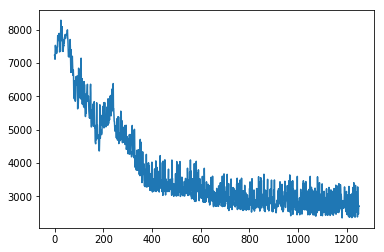

final distance is: 0.0


In [46]:
def optimize(initialPath, tStep=200, alpha=0.97,T=1000):
    distances = [getLength(initialPath)]
    paths = [initialPath]
    distance = distances[0]
    for t in np.arange(tStep):
        newPath = exchange(list(initialPath))
        
        oldD = distance
        newD = getLength(newPath)
        
        if np.exp((oldD - newD)/temp(t,alpha,T)) > np.random.random():
            initialPath = newPath
            distance = newD
        
        distances.append(newD)
        paths.append(newPath)
        
    
    return paths, distances


best, distanceList = optimize(getPath(len(capitals_list)), 1250, alpha=0.99,T=1000)

plt.plot(np.arange(len(distanceList)), distanceList)
plt.show()
#show_path(best, best[0])
#plt.show()
print("final distance is: {}".format(np.min(dist)))

### Runtime improvements

In [44]:
# Currently, need to calculate the distance between every city, on every iteration - better to cache the distances,
# and label cities as an index.

def getIndexPath(n=8):
    # returns numbers from 0 to n in a random order
    path = []
    mod_capitals = list(range(n))

    for i in range(0,n):
        path.append(mod_capitals.pop(np.random.randint(len(mod_capitals))))

    return path

# Build a matrix of distances between cities, where dist[a][b] is the distance from a to b

dist = [[np.sum((np.array([j for j in a]) - np.array([j for j in b]))**2) ** 0.5 for b in coords(capitals_list)]for a in coords(capitals_list)]

print(dist[1][3]) # corresponds to the distance between captials_list[1] and [3]

# It's also useful to define a new function to calculate a length for an index path

def indexPathLength(path):
    #print(path)
    mask = np.zeros(shape=(len(path),len(path)))
    path = np.append(path, path[0])
    #Interesting property about numpy arrays: we can index using another array to select many elements at once
    mask[path[:-1], path[1:]] = 1
    return np.einsum('ij,ij',mask,dist) #multiplies the mask and dist matrices pairwise, and sums the result

print(getIndexPath(len(capitals_list)))


216.02703534511596
[14, 4, 7, 13, 8, 24, 17, 27, 21, 2, 26, 19, 1, 22, 18, 29, 28, 20, 3, 15, 23, 11, 6, 16, 12, 5, 25, 0, 9, 10]


In [50]:
# Instead of recalculating the path distance, it's more efficient to just modify the previous one:
# this takes 4 operations, rather than len(path) - however, when we exchange, we now need to know what
# indices were switched

def exchangeAndReturnPairs(path):
    #choose two random points, and reverse the path between them - exclude the first and last item though, to avoid
    #problems with thr path not being cyclic anymore
    
    a = 1 + np.random.randint(len(path) - 2)
    b = a + np.random.randint(1, len(path) - a)
    
    a = 1 + np.random.randint(len(path)-2)
    b = a + np.random.randint(1, len(path) - a)
    return path[:a] + path[b:a-1:-1] + path [b+1:], a, b

# myPath = getIndexPath()
# print(myPath)
# print(exchange(myPath))

def optimizeFast(initialPath, tStep=200, alpha=0.97,T=1000):
    distance = indexPathLength(initialPath)
    distances = [distance]
    paths = [initialPath]
    numCities = len(initialPath)
    
    for t in np.arange(tStep):
        newPath, a, b = exchangeAndReturnPairs(list(initialPath))
        
        oldD = distance
        mask = np.zeros(shape=(numCities,numCities))
        # subtract the two segments we deleted, and add the two new ones
        mask[[initialPath[a],initialPath[b]],[initialPath[(a-1)%numCities],initialPath[(b+1)%numCities]]] = -1
        mask[[initialPath[b],initialPath[a]],[initialPath[(a-1)%numCities],initialPath[(b+1)%numCities]]] = 1
        newD = oldD + np.einsum('ij,ij',mask,dist)
        
        if np.exp((oldD - newD)/temp(t,alpha,T)) > np.random.random():
            initialPath = newPath
            distance = newD
        
        distances.append(newD)
        paths.append(newPath)
        
    
    return paths, distances


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in exp


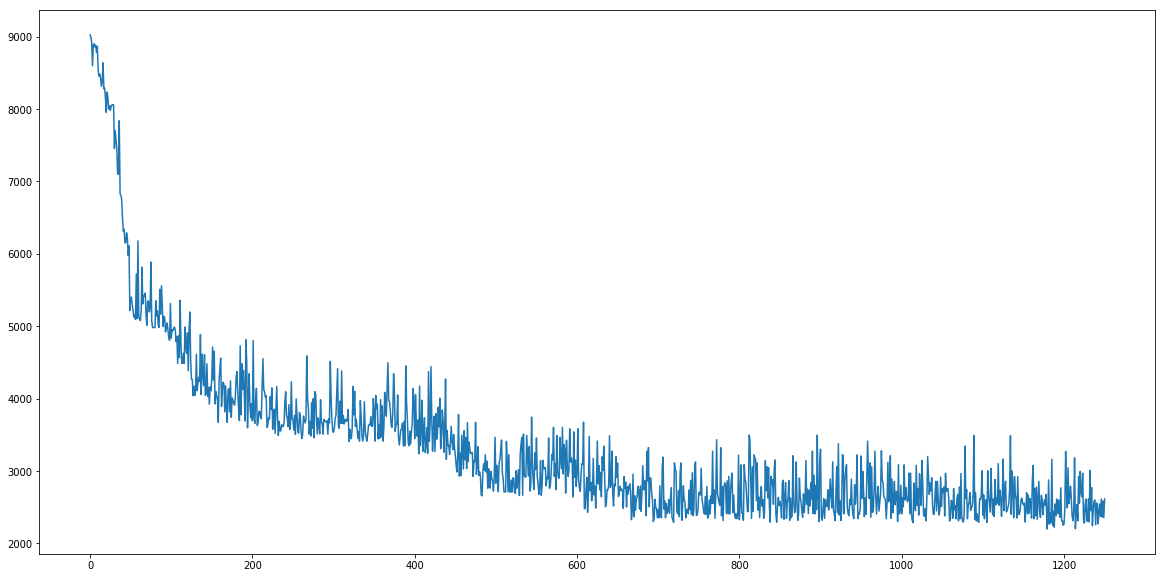

final distance is: 2198.1996154394046


In [118]:
pathList, distanceList = optimizeFast(getIndexPath(len(capitals_list)), 1250, alpha=0.80,T=1000)

plt.plot(np.arange(len(distanceList)), distanceList)
plt.show()
#show_path(best, best[0])
#plt.show()
print("final distance is: {}".format(np.min(distanceList)))

### Speed comparison

In [54]:
%timeit pathList, distanceList = optimize(getPath(len(capitals_list)), 1250, alpha=0.99,T=1000)

725 ms ± 11.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


In [55]:
%timeit pathList, distanceList = optimizeFast(getIndexPath(len(capitals_list)), 1250, alpha=0.99,T=1000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in exp


195 ms ± 12.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Interfacing with the solver

In [119]:
def shortestPath(initialPath, iterations=20, tstep=1250, alpha=0.90, T=1000, silent=False):
    best=initialPath
    distance=indexPathLength(initialPath)
    
    for _ in range(iterations):
        newPaths, newDistances = optimizeFast(initialPath,tstep,alpha,T)
        
        runBestIndex = np.argmin(newDistances)
        if not silent : print("run #{}, best distance:{}".format(_+1,newDistances[runBestIndex]))
        if newDistances[runBestIndex] < distance :
            distance = newDistances[runBestIndex]
            best = newPaths[runBestIndex]
        
    return best, distance

best, distance = shortestPath(getIndexPath(len(capitals_list)), 100, silent=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in exp


Distance is 2178.9987347808774


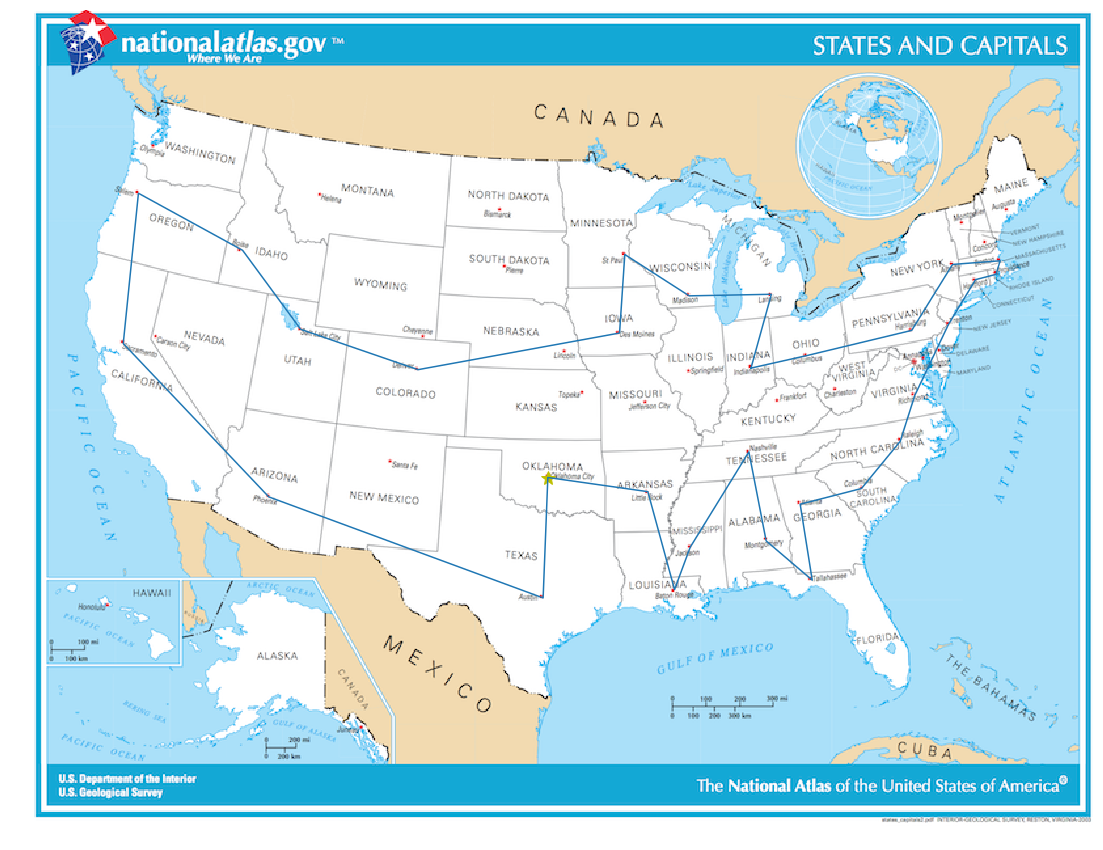

In [120]:
show_path(np.array(capitals_list)[best],capitals_list[0])
print("Distance is {}".format(distance))

# Part 2 - Tacoma bridge

In [77]:
# Useful constants

tstart=0
tend=100

d=0.01
a=1
M=2500
K=10000
l=6

In [78]:
# implement a discrete coupled diffeq solver

def tacoma(dt=0.01, cromer=False, y_init = 0.0, theta_init = 0.0, z_init = 0.0, gamma_init = 0.0, eqs = lambda x : x):

    # Create the variables to store our results
    times=np.arange(tstart, tend+dt, dt)  # Create the array of model times
    Nt=len(times)                         # Number of time-steps
    y=np.zeros(Nt)                   
    theta=np.zeros(Nt)                   
    z=np.zeros(Nt) 
    gamma=np.zeros(Nt) 

    # Set our initial conditions
    y[0] = y_init
    theta[0] = theta_init
    z[0] = z_init
    gamma[0] = gamma_init
  


    # Loop over all of our times and integrate the model
    for n in range(Nt-1):
        #Next step
        
        x_new = eqs([y[n], z[n], theta[n], gamma[n], times[n]])


        # Time-step the angle. If we are using 'Taylor' or 'Cromer"
        z[n+1] = z[n] + x_new[1] * dt
        gamma[n+1] = gamma[n] + x_new[3] * dt
        
        if cromer:
            
            y[n+1] = y[n] + z[n+1] * dt
            theta[n+1] = theta[n] + gamma[n+1] * dt
        
        else:
            
            y[n+1] = y[n] + z[n] * dt
            theta[n+1] = theta[n] + gamma[n] * dt
    return times, theta, y

In [79]:
def forceModel(x):
    # x is a vector of the form [y, y', theta, theta']
    # want to return the respective derivatives - [y', y'', theta', theta'']
    
    y = x[0]
    y_1 = x[1]
    theta = x[2]
    theta_1 = x[3]
    
    #these are the forces    
    y_2 = -d * y_1 - (K/M * (y - l * np.sin(theta)) + K/M * (y + l * np.sin(theta)))
    
    theta_2 = -d * theta_1 + 3 * np.cos(theta) / l * (K/M * (y - l * np.sin(theta)) - K/M * (y + l * np.sin(theta)))
    
    #we already have y_1 and theta_1
    
    return [y_1, y_2, theta_1, theta_2]

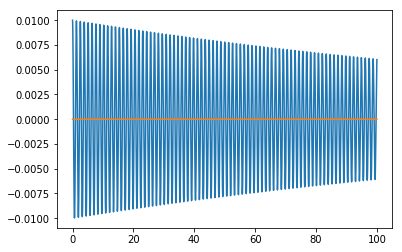

In [81]:
# Run the solver

times, theta, y = tacoma(cromer=True, theta_init = 0.01, eqs = forceModel)

plt.plot(times, theta)
plt.plot(times, y)

plt.show()

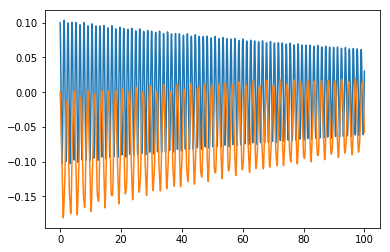

In [82]:
def betterForceModel(x):
    # x is a vector of the form [y, y', theta, theta']
    # want to return the respective derivatives - [y', y'', theta', theta'']
    
    y = x[0]
    y_1 = x[1]
    theta = x[2]
    theta_1 = x[3]
    
    #these are the forces    
    y_2 = -d * y_1 - K/(M*a) * (np.exp(a * (y - l * np.sin(theta))) - 1 + np.exp(a * (y + l * np.sin(theta))) - 1)
    
    theta_2 = -d * theta_1 + 3 * np.cos(theta) / l * K / (M * a) * ( np.exp(a * (y - l * np.sin(theta))) - np.exp(a * (y + l * np.sin(theta))))
    #we already have y_1 and theta_1
    
    return [y_1, y_2, theta_1, theta_2]

times, theta, y = tacoma(cromer=True, theta_init = 0.1, y_init = 0.0, eqs = betterForceModel)

plt.plot(times, theta)
plt.plot(times, y)

plt.show()

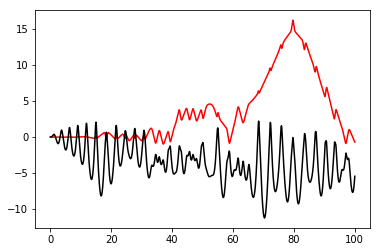

In [83]:
def windForceModel(x, w = 3, A = 1):
    # x is a vector of the form [y, y', theta, theta', time]
    # want to return the respective derivatives - [y', y'', theta', theta'']
    
    y = x[0]
    y_1 = x[1]
    theta = x[2]
    theta_1 = x[3]
    
    #these are the forces    
    y_2 = -d * y_1 - K/(M*a) * (np.exp(a * (y - l * np.sin(theta))) - 1 + np.exp(a * (y + l * np.sin(theta))) - 1)
    
    #add the wind component
    y_2 += A * np.sin(w * x[4])
    
    theta_2 = -d * theta_1 + 3 * np.cos(theta) / l * K / (M * a) * ( np.exp(a * (y - l * np.sin(theta))) - np.exp(a * (y + l * np.sin(theta))))
    #we already have y_1 and theta_1
    
    return [y_1, y_2, theta_1, theta_2]




times, theta, y = tacoma(cromer=True, theta_init = 0.01, eqs = lambda x : windForceModel(x, w = 2.343434, A =2))

plt.plot(times, theta, 'r')
plt.plot(times, y, 'k')

plt.show()

Resonance for theta occurs at: 2.3434343434343434


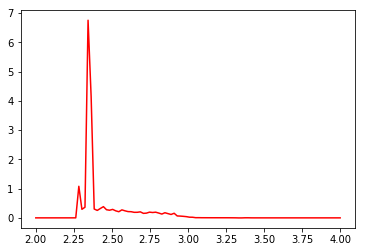

Resonance for Y occurs at: 2.3434343434343434


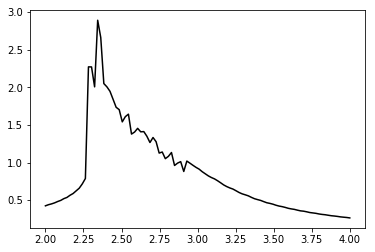

In [84]:
# Note - this takes a while to run

rmsY = []
rmsT = []

w_array = np.linspace(2,4,100)

for w in w_array:
    times, theta, y = tacoma(cromer=True, theta_init = 0.01, eqs = lambda x : windForceModel(x, w=w, A =2))
    
    rmsY.append(np.std(y))
    rmsT.append(np.std(theta))
    
#     rmsY.append(np.sqrt(np.mean(y ** 2)))
#     rmsT.append(np.sqrt(np.mean(theta ** 2)))

#plt.plot(w_array, rmsY,'k')
plt.plot(w_array, rmsT,'r')
print("Resonance for theta occurs at: {}".format(w_array[np.argmax(rmsT)]))
plt.show()

plt.plot(w_array, rmsY,'k')
print("Resonance for Y occurs at: {}".format(w_array[np.argmax(rmsY)]))
plt.show()

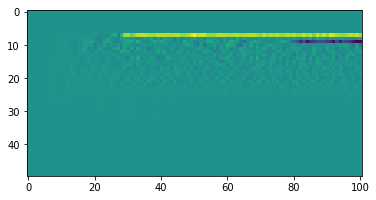

In [91]:
#heatmap with theta(t,w)

plt.imshow([tacoma(cromer=True, theta_init = 0.01, eqs = lambda x : windForceModel(x, w=w, A =2))[1][::100] for w in np.linspace(2,4,50)])

plt.show()

frequency = 2.0, RMS value for theta= 0.005776379670023036


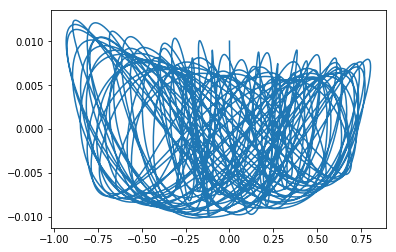

frequency = 2.5, RMS value for theta= 0.24939620599811935


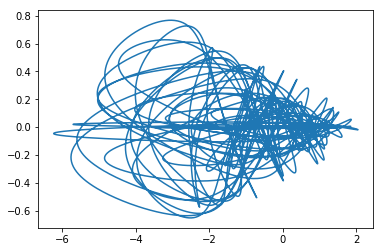

frequency = 3.0, RMS value for theta= 0.03558421183024278


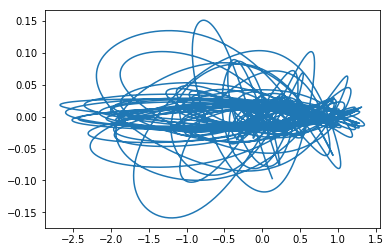

frequency = 3.5, RMS value for theta= 0.005761975596415069


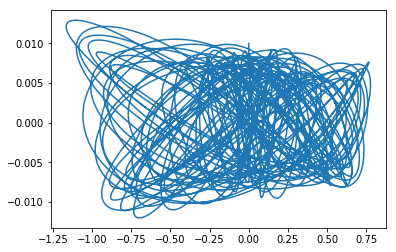

frequency = 4.0, RMS value for theta= 0.005750646400867286


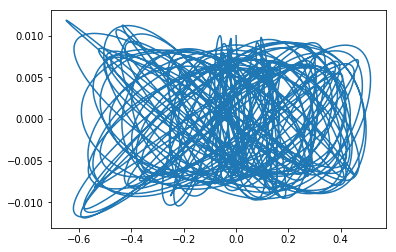

frequency = 2.3434343434343434, RMS value for theta= 6.7520554922088865


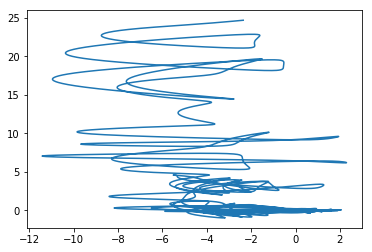

In [92]:
for w in np.linspace(2,4,5):
    times, theta, y = tacoma(cromer=True, theta_init = 0.01, eqs = lambda x : windForceModel(x, w=w, A =2))
    plt.plot(y,theta)
    print("frequency = {0}, RMS value for theta= {1}".format(w, np.std(theta)))
    plt.show()

    
w = 2.3434343434343434
times, theta, y = tacoma(cromer=True, theta_init = 0.01, eqs = lambda x : windForceModel(x, w=w, A =2))
plt.plot(y,theta)
print("frequency = {0}, RMS value for theta= {1}".format(w, np.std(theta)))
plt.show()


# Part 3 - Image compression

In [93]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

shape is 1000 x 1600


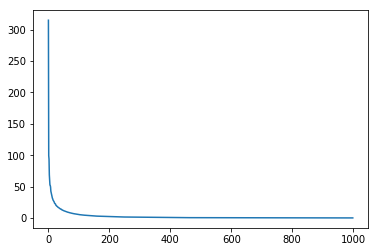

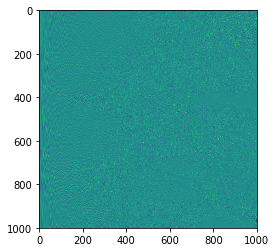

shape is 638 x 960


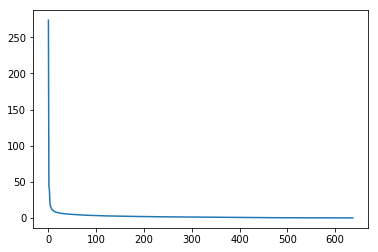

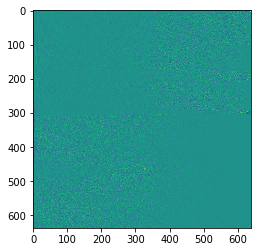

In [94]:
names = ["tiger.png", "beach.png"]

imgs = [rgb2gray(mpimg.imread(name)) for name in names]

def showEig(img):
    m,n = np.shape(img)
    print("shape is {0} x {1}".format(m,n))
    
    U, eigs, V = np.linalg.svd(img)
    
    [plt.plot(range(len(eigs)), eigs)]
    plt.show()
    
    plt.imshow(U)
    plt.show()

def getEigs(img):
    m,n = np.shape(img)
    U, eigs, V = np.linalg.svd(img)
    
    return eigs
    
showEig(imgs[0])
showEig(imgs[1])


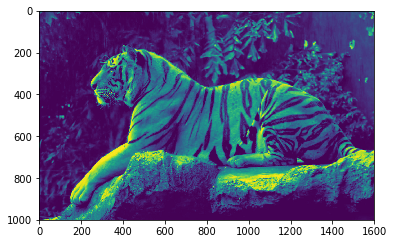

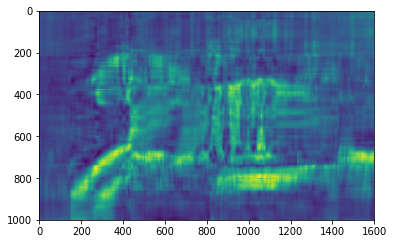

In [96]:
def compress(img, components = 500):
    U, S, T = np.linalg.svd(img)
    
    compressed_S = np.zeros((img.shape[0],img.shape[1]))
    
    for i in range(components):
        compressed_S[i][i] = S[i]
    
    return np.dot(U, np.dot(compressed_S, T))

plt.imshow(imgs[0])
plt.show()
plt.imshow(compress(imgs[0], 10))
plt.show()

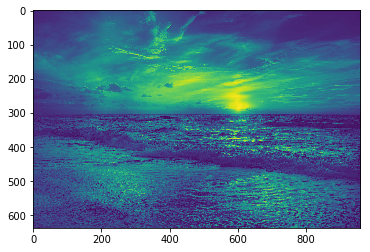

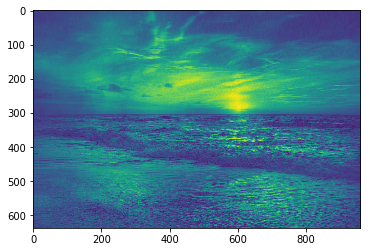

In [97]:
plt.imshow(imgs[1])
plt.show()
plt.imshow(compress(imgs[1], 100))
plt.show()

In [98]:
def cutout(img, start = 0, end = 500):
    U, S, T = np.linalg.svd(img)
    
    compressed_S = np.zeros((img.shape[0],img.shape[1]))
    
    for i in [i for i in range(start)] + [i for i in range(end, len(S))]:
        compressed_S[i][i] = S[i]
    
    return np.dot(U, np.dot(compressed_S, T))

### Noise removal

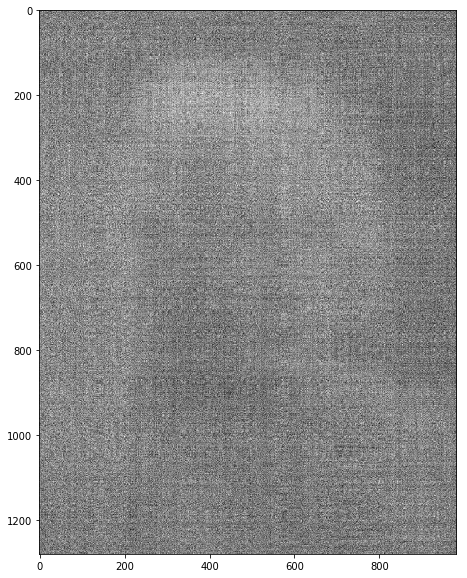

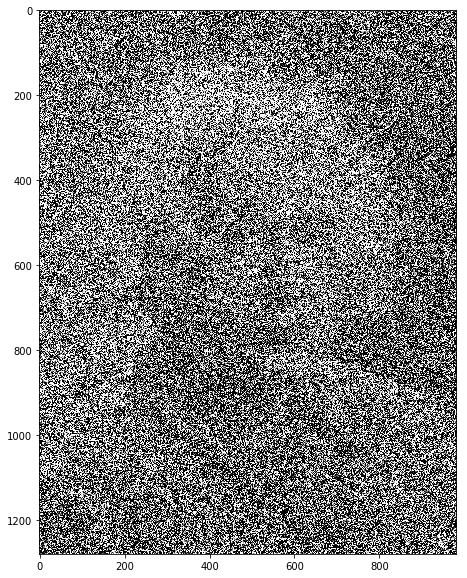

In [100]:
guest = rgb2gray(mpimg.imread("guest.png"))

#showEig(guest)
plt.rcParams["figure.figsize"] = (20,10)

#eigs = getEigs(guest)
#plt.plot(range(len(eigs[2:])), eigs[2:])
#plt.show()

# plt.imshow(compress(cutout(guest, 2,5), 600),cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
# plt.show()

plt.imshow(compress(guest, 30),cmap=plt.get_cmap('gray'))
plt.show()

plt.imshow(guest,cmap=plt.get_cmap('gray'))
plt.show()


def totalLap(img):
    total = 0
    for i in range(1, len(img) - 1):
        total += np.abs(np.sum(img[i] - img[i-1])) + np.abs(np.sum(img[i] - img[i+1]))
    
    return total


def getVar(img, num):
    U, S, T = np.linalg.svd(img)
    var = []
    
    for i in range(0,num):
        compressed_S = np.zeros((img.shape[0],img.shape[1]))
    
        compressed_S[i][i] = S[i]
    
        current = np.dot(U, np.dot(compressed_S, T))
        var.append(totalLap(current))
    return var


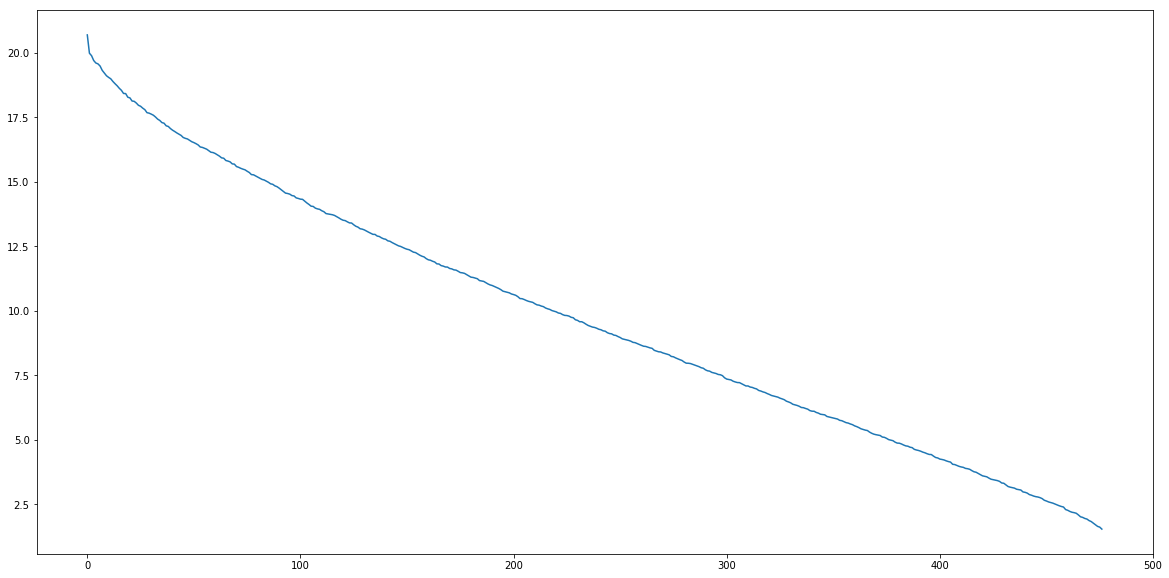

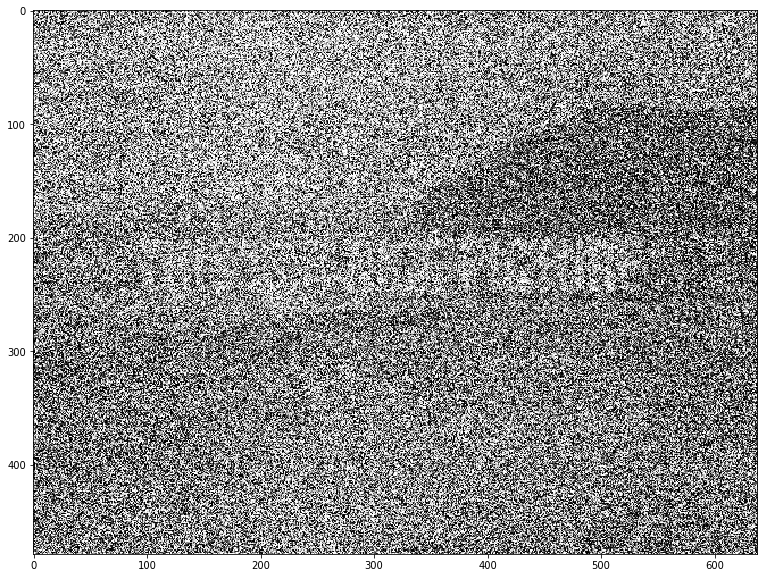

In [101]:
guest = rgb2gray(mpimg.imread("code.png"))

#showEig(guest)
plt.rcParams["figure.figsize"] = (20,10)

eigs = getEigs(guest)
plt.plot(range(len(eigs[2:])), eigs[2:])
plt.show()

plt.imshow(compress(cutout(guest, 5,30), 400),cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

# plt.imshow(compress(guest, 30),cmap=plt.get_cmap('gray'))
plt.show()